<a id=top-page></a>
# Cost function assessment of swiss roll data projections

In this notebook, we explore the application of the cost function, $\mathcal{L}$, to embeddings generated with various dimensionality reduction and manifold learning techniques. We use the classic swiss roll dataset where the `color` variable is the dependent variable, $\phi$.

The analysis in this notebook is performed in the following steps:

- [Create the dataset](#original)
- Create projections with:
    - [Principal component analysis](#PCA)
    - [Multidimensional scaling](#MDS)
    - [Linear distriminant analysis](#LDA)
    - [Distance metric learning](#DML)
    - [Isomap](#isomap)
    - [Locally linear embedding](#LLE)
    - [Hessian locally linear embedding](#HLLE)
    - [Local tangent space alignment](#LTSA)
    - [t-SNE](#TSNE)
    - [Uniform manifold approximation and projection](#UMAP)
    - [Spectral embedding](#SE)
    - [Autoencoders](#AE)
- [Plot a comparison of various embeddings](#plot-embeddings)
- [Plot a comparison of $\hat{\mathcal{D}}(\sigma)$](#plot-D-hat)

***

In [1]:
%run -i imports.py
%matplotlib inline

In [2]:
bandwidth_values = np.logspace(-3.5, 2, 200)
penalty = 'log-sigma-over-peak'
norm = 'max'
power = 1
colormap = 'coolwarm'
save_figures = True

<a id=original></a>
***
## Create the dataset

[Go to the top](#top-page)

In [3]:
X, color = datasets.make_swiss_roll(n_samples=3000, random_state=random_seed)
color = color[:,None]
(n_observations, n_variables) = np.shape(X)

In [4]:
variance_data = analysis.compute_normalized_variance(X, 
                                                     color, 
                                                     depvar_names=['var'], 
                                                     bandwidth_values=bandwidth_values)

derivative, sigma, _ = analysis.normalized_variance_derivative(variance_data)

In [5]:
cost_3D = analysis.cost_function_normalized_variance_derivative(variance_data, 
                                                                penalty_function=penalty, 
                                                                power=power,
                                                                norm=norm, 
                                                                integrate_to_peak=False)

In [6]:
print(cost_3D)

0.9802133699792938


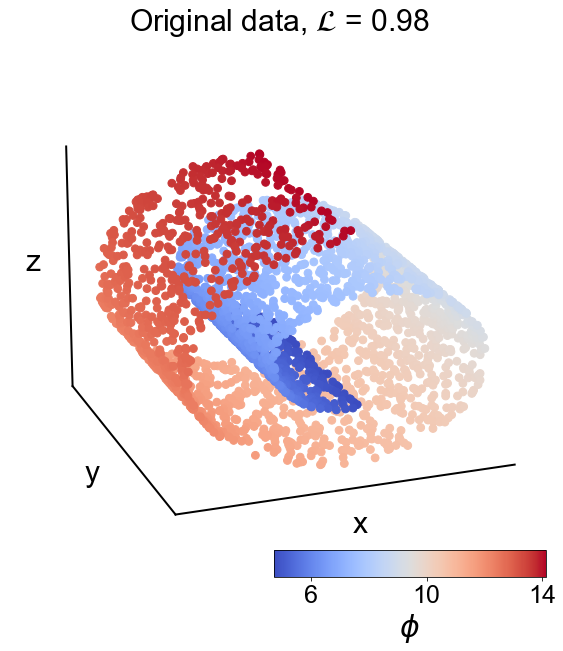

In [16]:
fig = plt.figure(figsize=(10, 10))
spec = fig.add_gridspec(ncols=1, nrows=1, width_ratios=[1], height_ratios=[1])
ax = fig.add_subplot(spec[0,0], projection='3d')
scat = ax.scatter(X[:,0], X[:,1], X[:,2], c=color.ravel(), s=60, marker='o', cmap=colormap, alpha=1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.tick_params(pad=5)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.view_init(elev=20, azim=70)
ax.set_xlabel('x', fontsize=30)
ax.set_ylabel('y', fontsize=30)
ax.set_zlabel('z', fontsize=30)
plt.title('Original data, $\mathcal{L}$ = ' + str(round(cost_3D,2)), fontsize=30)
cbaxes = inset_axes(ax, width="50%", height="5%", loc='lower right')
cbar = plt.colorbar(scat, ticks=[6,10,14], orientation='horizontal', aspect=8, cax=cbaxes)
cbar.ax.set_xlabel('$\phi$', fontsize=30, rotation=0)
for axis in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
    axis.line.set_linewidth(2)
for t in cbar.ax.get_xticklabels():
     t.set_fontsize(25)

if save_figures: plt.savefig('../figures/swiss-roll-3d.png', dpi=300, bbox_inches='tight')

<a id=PCA></a>
***
## Principal component analysis

[Go to the top](#top-page)

In [8]:
tic = time.perf_counter()

pca = reduction.PCA(X, scaling='auto', n_components=2)
X_PCA = pca.transform(X)

variance_data_PCA = analysis.compute_normalized_variance(X_PCA, 
                                                         color, 
                                                         depvar_names=['var'], 
                                                         bandwidth_values=bandwidth_values)

derivative_PCA, sigma_PCA, _ = analysis.normalized_variance_derivative(variance_data_PCA)

toc = time.perf_counter()

print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

	Time it took: 0.1 minutes.
----------------------------------------


In [9]:
cost_PCA = analysis.cost_function_normalized_variance_derivative(variance_data_PCA, 
                                                                 penalty_function=penalty,
                                                                 power=power,
                                                                 norm=norm, 
                                                                 integrate_to_peak=False)

In [10]:
print(cost_PCA)

2.5661063285717773


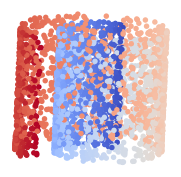

In [11]:
reduction.plot_2d_manifold(X_PCA[:,0], 
                           X_PCA[:,1], 
                           s=30,
                           color=color, 
                           clean=True,
                           figure_size=(3,3), 
                           color_map=colormap);

<a id=MDS></a>
***
## Multidimensional scaling

[Go to the top](#top-page)

In [12]:
tic = time.perf_counter()

X_MDS = manifold.MDS(n_components=2, random_state=random_seed).fit_transform(X)

variance_data_MDS = analysis.compute_normalized_variance(X_MDS,
                                                         color,
                                                         depvar_names=['var'],
                                                         bandwidth_values=bandwidth_values)

derivative_MDS, sigma_MDS, _ = analysis.normalized_variance_derivative(variance_data_MDS)

toc = time.perf_counter()

print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

	Time it took: 3.3 minutes.
----------------------------------------


In [13]:
cost_MDS = analysis.cost_function_normalized_variance_derivative(variance_data_MDS,
                                                                 penalty_function=penalty,
                                                                 power=power,
                                                                 norm=norm,
                                                                 integrate_to_peak=False)

In [14]:
print(cost_MDS)

1.2495600446436619


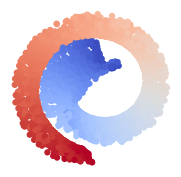

In [15]:
reduction.plot_2d_manifold(X_MDS[:,0], 
                           X_MDS[:,1], 
                           s=40,
                           color=color, 
                           clean=True,
                           figure_size=(3,3), 
                           color_map=colormap);

<a id=LDA></a>
***
## Linear discriminant analysis

[Go to the top](#top-page)

In [16]:
tic = time.perf_counter()

(idx, borders) = preprocess.variable_bins(color, 5)
X_LDA = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, idx)

variance_data_LDA = analysis.compute_normalized_variance(X_LDA,
                                                         color,
                                                         depvar_names=['var'], 
                                                         bandwidth_values=bandwidth_values)

derivative_LDA, sigma_LDA, _ = analysis.normalized_variance_derivative(variance_data_LDA)

toc = time.perf_counter()

print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

	Time it took: 0.1 minutes.
----------------------------------------


In [17]:
cost_LDA = analysis.cost_function_normalized_variance_derivative(variance_data_LDA, 
                                                                 penalty_function=penalty,
                                                                 power=power,
                                                                 norm=norm, 
                                                                 integrate_to_peak=False)

In [18]:
print(cost_LDA)

0.9493330477742402


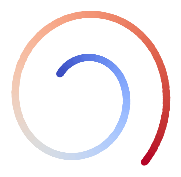

In [19]:
reduction.plot_2d_manifold(X_LDA[:,0], 
                           X_LDA[:,1], 
                           s=40,
                           color=color, 
                           clean=True,
                           figure_size=(3,3), 
                           color_map=colormap);

<a id=DML></a>
***
## Distance metric learning

[Go to the top](#top-page)

In [20]:
tic = time.perf_counter()

(idx, borders) = preprocess.variable_bins(color, 5)
dml_object = DML_eig()
dml_object.fit(X,idx)
X_DML = dml_object.transform(X)
X_DML = X_DML[:,0:2]

variance_data_DML = analysis.compute_normalized_variance(X_DML, 
                                                         color,
                                                         depvar_names=['var'], 
                                                         bandwidth_values=bandwidth_values)

derivative_DML, sigma_DML, _ = analysis.normalized_variance_derivative(variance_data_DML)

toc = time.perf_counter()

print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

	Time it took: 12.7 minutes.
----------------------------------------


In [21]:
cost_DML = analysis.cost_function_normalized_variance_derivative(variance_data_DML, 
                                                                 penalty_function=penalty,
                                                                 power=power,
                                                                 norm=norm, 
                                                                 integrate_to_peak=False)

In [22]:
print(cost_DML)

1.589295638536652


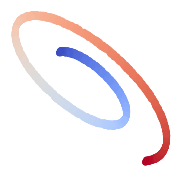

In [23]:
reduction.plot_2d_manifold(X_DML[:,0], 
                           X_DML[:,1], 
                           s=40,
                           color=color, 
                           clean=True,
                           figure_size=(3,3), 
                           color_map=colormap);

<a id=isomap></a>
***
## Isomap

[Go to the top](#top-page)

In [24]:
tic = time.perf_counter()

X_IMAP = manifold.Isomap(n_components=2).fit_transform(X)

variance_data_IMAP = analysis.compute_normalized_variance(X_IMAP, 
                                                          color, 
                                                          depvar_names=['var'], 
                                                          bandwidth_values=bandwidth_values)

derivative_IMAP, sigma_IMAP, _ = analysis.normalized_variance_derivative(variance_data_IMAP)

toc = time.perf_counter()

print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

	Time it took: 0.1 minutes.
----------------------------------------


In [25]:
cost_IMAP = analysis.cost_function_normalized_variance_derivative(variance_data_IMAP, 
                                                                  penalty_function=penalty,
                                                                  power=power,
                                                                  norm=norm, 
                                                                  integrate_to_peak=False)

In [26]:
print(cost_IMAP)

1.2370445274804966


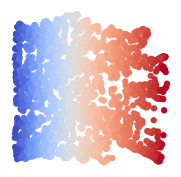

In [27]:
reduction.plot_2d_manifold(X_IMAP[:,0], 
                           X_IMAP[:,1], 
                           s=40,
                           color=color, 
                           clean=True,
                           figure_size=(3,3), 
                           color_map=colormap);

<a id=LLE></a>
***
## Locally linear embedding

[Go to the top](#top-page)

In [28]:
tic = time.perf_counter()

X_LLE, _ = manifold.locally_linear_embedding(X, n_neighbors=12, n_components=2, random_state=random_seed)

variance_data_LLE = analysis.compute_normalized_variance(X_LLE, 
                                                         color, 
                                                         depvar_names=['var'], 
                                                         bandwidth_values=bandwidth_values)

derivative_LLE, sigma_LLE, _ = analysis.normalized_variance_derivative(variance_data_LLE)

toc = time.perf_counter()

print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

	Time it took: 0.1 minutes.
----------------------------------------


In [29]:
cost_LLE = analysis.cost_function_normalized_variance_derivative(variance_data_LLE,
                                                                 penalty_function=penalty,
                                                                 power=power,
                                                                 norm=norm,
                                                                 integrate_to_peak=False)

In [30]:
print(cost_LLE)

1.2837895326388724


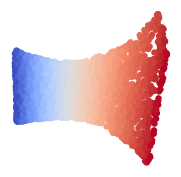

In [31]:
reduction.plot_2d_manifold(X_LLE[:,0], 
                           X_LLE[:,1], 
                           s=40,
                           color=color, 
                           clean=True,
                           figure_size=(3,3), 
                           color_map=colormap);

<a id=HLLE></a>
***
## Hessian LLE

[Go to the top](#top-page)

In [32]:
tic = time.perf_counter()

X_HLLE, _ = manifold.locally_linear_embedding(X, n_neighbors=12, method='hessian', n_components=2, random_state=random_seed)

variance_data_HLLE = analysis.compute_normalized_variance(X_HLLE, 
                                                          color, 
                                                          depvar_names=['var'], 
                                                          bandwidth_values=bandwidth_values)

derivative_HLLE, sigma_HLLE, _ = analysis.normalized_variance_derivative(variance_data_HLLE)

toc = time.perf_counter()

print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

	Time it took: 0.1 minutes.
----------------------------------------


In [33]:
cost_HLLE = analysis.cost_function_normalized_variance_derivative(variance_data_HLLE,
                                                                  penalty_function=penalty,
                                                                  power=power,
                                                                  norm=norm, 
                                                                  integrate_to_peak=False)

In [34]:
print(cost_HLLE)

1.2494019300924306


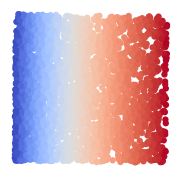

In [35]:
reduction.plot_2d_manifold(X_HLLE[:,0], 
                           X_HLLE[:,1], 
                           s=40,
                           color=color, 
                           clean=True,
                           figure_size=(3,3), 
                           color_map=colormap);

<a id=LTSA></a>
***
## Local tangent space alignment

[Go to the top](#top-page)

In [36]:
tic = time.perf_counter()

X_LTSA, _ = manifold.locally_linear_embedding(X, n_neighbors=12, method='ltsa', n_components=2, random_state=random_seed)

variance_data_LTSA = analysis.compute_normalized_variance(X_LTSA, 
                                                          color, 
                                                          depvar_names=['var'],
                                                          bandwidth_values=bandwidth_values)

derivative_LTSA, sigma_LTSA, _ = analysis.normalized_variance_derivative(variance_data_LTSA)

toc = time.perf_counter()

print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

	Time it took: 0.1 minutes.
----------------------------------------


In [37]:
cost_LTSA = analysis.cost_function_normalized_variance_derivative(variance_data_LTSA, 
                                                                  penalty_function=penalty,
                                                                  power=power,
                                                                  norm=norm, 
                                                                  integrate_to_peak=False)

In [38]:
print(cost_LTSA)

1.2493809144925356


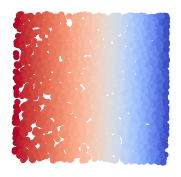

In [39]:
reduction.plot_2d_manifold(X_LTSA[:,0], 
                           X_LTSA[:,1], 
                           s=40,
                           color=color, 
                           clean=True,
                           figure_size=(3,3), 
                           color_map=colormap);

<a id=TSNE></a>
***
## t-SNE

[Go to the top](#top-page)

In [40]:
tic = time.perf_counter()

X_TSNE = manifold.TSNE(n_components=2, init="random", random_state=random_seed).fit_transform(X)

variance_data_TSNE = analysis.compute_normalized_variance(X_TSNE, 
                                                          color, 
                                                          depvar_names=['var'], 
                                                          bandwidth_values=bandwidth_values)

derivative_TSNE, sigma_TSNE, _ = analysis.normalized_variance_derivative(variance_data_TSNE)

toc = time.perf_counter()

print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

('WARNING: casting training data as', <class 'float'>)
	Time it took: 0.3 minutes.
----------------------------------------


In [41]:
cost_TSNE = analysis.cost_function_normalized_variance_derivative(variance_data_TSNE,
                                                                  penalty_function=penalty,
                                                                  power=power,
                                                                  norm=norm,
                                                                  integrate_to_peak=False)

In [42]:
print(cost_TSNE)

1.1966024976138745


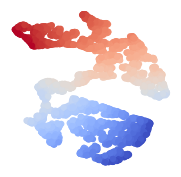

In [43]:
reduction.plot_2d_manifold(X_TSNE[:,0], 
                           X_TSNE[:,1], 
                           s=40,
                           color=color, 
                           clean=True,
                           figure_size=(3,3), 
                           color_map=colormap);

<a id=UMAP></a>
***
## Uniform manifold approximation and projection

[Go to the top](#top-page)

In [44]:
tic = time.perf_counter()

X_UMAP = umap.UMAP(n_components=2, random_state=random_seed).fit_transform(X)

variance_data_UMAP = analysis.compute_normalized_variance(X_UMAP, 
                                                          color, 
                                                          depvar_names=['var'], 
                                                          bandwidth_values=bandwidth_values)

derivative_UMAP, sigma_UMAP, _ = analysis.normalized_variance_derivative(variance_data_UMAP)

toc = time.perf_counter()

print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

('WARNING: casting training data as', <class 'float'>)
	Time it took: 0.3 minutes.
----------------------------------------


In [45]:
cost_UMAP = analysis.cost_function_normalized_variance_derivative(variance_data_UMAP, 
                                                                  penalty_function=penalty,
                                                                  power=power,
                                                                  norm=norm, 
                                                                  integrate_to_peak=False)

In [46]:
print(cost_UMAP)

1.0150228589607593


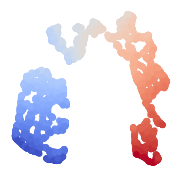

In [47]:
reduction.plot_2d_manifold(X_UMAP[:,0],
                           X_UMAP[:,1],
                           s=40,
                           color=color,
                           clean=True,
                           figure_size=(3,3),
                           color_map=colormap);

<a id=SE></a>
***
## Spectral embedding

[Go to the top](#top-page)

In [48]:
tic = time.perf_counter()

X_SE = manifold.SpectralEmbedding(n_components=2, n_neighbors=12, random_state=random_seed).fit_transform(X)

variance_data_SE = analysis.compute_normalized_variance(X_SE, 
                                                        color, 
                                                        depvar_names=['var'], 
                                                        bandwidth_values=bandwidth_values)

derivative_SE, sigma_SE, _ = analysis.normalized_variance_derivative(variance_data_SE)

toc = time.perf_counter()

print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

	Time it took: 0.1 minutes.
----------------------------------------


In [49]:
cost_SE = analysis.cost_function_normalized_variance_derivative(variance_data_SE, 
                                                                penalty_function=penalty,
                                                                power=power,
                                                                norm=norm, 
                                                                integrate_to_peak=False)

In [50]:
print(cost_SE)

0.9165185579400377


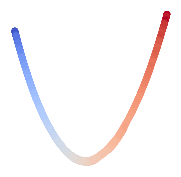

In [51]:
reduction.plot_2d_manifold(X_SE[:,0], 
                           X_SE[:,1], 
                           s=40,
                           color=color, 
                           clean=True,
                           figure_size=(3,3), 
                           color_map=colormap);

<a id=AE></a>
***
## Autoencoders

[Go to the top](#top-page)

In [52]:
tic = time.perf_counter()

tf.random.set_seed(random_seed)

X_CS, _, _ = preprocess.center_scale(X, scaling='auto')

sample_random = preprocess.DataSampler(np.zeros((n_observations,)).astype(int), random_seed=random_seed, verbose=False)
(idx_train, idx_test) = sample_random.random(80)
X_CS_train = X_CS[idx_train,:]
X_CS_test = X_CS[idx_test,:]

input_X = keras.Input(shape=(3,))
encoded_1 = layers.Dense(2, activation='tanh', kernel_initializer='glorot_uniform', bias_initializer='zeros')(input_X)
decoded = layers.Dense(3, activation='tanh', kernel_initializer='glorot_uniform', bias_initializer='zeros')(encoded_1)
autoencoder = keras.Model(input_X, decoded)
encoder = keras.Model(input_X, encoded_1)
encoded_input = keras.Input(shape=(2,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
autoencoder.fit(X_CS_train, X_CS_train,
                epochs=200,
                batch_size=50,
                shuffle=True,
                validation_data=(X_CS_test, X_CS_test), 
                verbose=0)

X_AE = encoder.predict(X_CS)

variance_data_AE = analysis.compute_normalized_variance(X_AE, 
                                                        color, 
                                                        depvar_names=['var'], 
                                                        bandwidth_values=bandwidth_values)

derivative_AE, sigma_AE, _ = analysis.normalized_variance_derivative(variance_data_AE)

toc = time.perf_counter()

print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

('WARNING: casting training data as', <class 'float'>)
	Time it took: 0.3 minutes.
----------------------------------------


In [53]:
cost_AE = analysis.cost_function_normalized_variance_derivative(variance_data_AE, 
                                                                penalty_function=penalty, 
                                                                power=power,
                                                                norm=norm, 
                                                                integrate_to_peak=False)

In [54]:
print(cost_AE)

3.7024819907168363


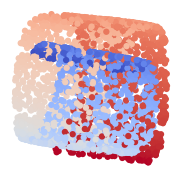

In [55]:
reduction.plot_2d_manifold(X_AE[:,0], 
                           X_AE[:,1], 
                           s=40,
                           color=color, 
                           clean=True,
                           figure_size=(3,3), 
                           color_map=colormap);

<a id=plot-embeddings></a>

***

## Plot a comparison of various embeddings

[Go to the top](#top-page)

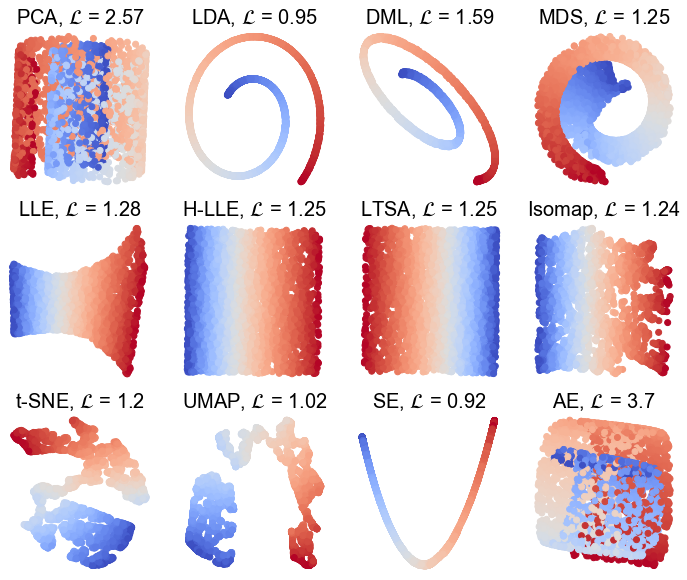

In [56]:
fig = plt.figure(figsize=(12, 10))
widths = [1, 1, 1, 1]
heights = [1, 1, 1]
spec = fig.add_gridspec(ncols=4, nrows=3, width_ratios=widths, height_ratios=heights)

ax = fig.add_subplot(spec[0,0])
ax.scatter(X_PCA[:, 0], X_PCA[:, 1], c=color.ravel(), cmap=colormap)
plt.axis("tight")
plt.xticks([]), plt.yticks([])
plt.title(r"PCA, $\mathcal{L}$ = " + str(round(cost_PCA,2)), fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

ax = fig.add_subplot(spec[0,1])
ax.scatter(X_LDA[:, 0], X_LDA[:, 1], c=color.ravel(), cmap=colormap)
plt.axis("tight")
plt.xticks([]), plt.yticks([])
plt.title("LDA, $\mathcal{L}$ = " + str(round(cost_LDA,2)), fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

ax = fig.add_subplot(spec[0,2])
ax.scatter(X_DML[:, 0], X_DML[:, 1], c=color.ravel(), cmap=colormap)
plt.axis("tight")
plt.xticks([]), plt.yticks([])
plt.title("DML, $\mathcal{L}$ = " + str(round(cost_DML,2)), fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

ax = fig.add_subplot(spec[0,3])
ax.scatter(X_MDS[:, 0], X_MDS[:, 1], c=color.ravel(), cmap=colormap)
plt.axis("tight")
plt.xticks([]), plt.yticks([])
plt.title("MDS, $\mathcal{L}$ = " + str(round(cost_MDS,2)), fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

# ----------------------------------------

ax = fig.add_subplot(spec[1,0])
ax.scatter(X_LLE[:, 0], X_LLE[:, 1], c=color.ravel(), cmap=colormap)
plt.axis("tight")
plt.xticks([]), plt.yticks([])
plt.title("LLE, $\mathcal{L}$ = " + str(round(cost_LLE,2)), fontsize=20)
plt.xlim([np.min(X_LLE[:, 0])+0.1*np.min(X_LLE[:, 0]),np.max(X_LLE[:, 0])+0.1*np.max(X_LLE[:, 0])])
plt.ylim([np.min(X_LLE[:, 1])+0.1*np.min(X_LLE[:, 1]),np.max(X_LLE[:, 1])+0.1*np.max(X_LLE[:, 1])])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

ax = fig.add_subplot(spec[1,1])
ax.scatter(X_HLLE[:, 0], X_HLLE[:, 1], c=color.ravel(), cmap=colormap)
plt.axis("tight")
plt.xticks([]), plt.yticks([])
plt.title("H-LLE, $\mathcal{L}$ = " + str(round(cost_HLLE,2)), fontsize=20)
plt.xlim([np.min(X_HLLE[:, 0])+0.1*np.min(X_HLLE[:, 0]),np.max(X_HLLE[:, 0])+0.1*np.max(X_HLLE[:, 0])])
plt.ylim([np.min(X_HLLE[:, 1])+0.1*np.min(X_HLLE[:, 1]),np.max(X_HLLE[:, 1])+0.1*np.max(X_HLLE[:, 1])])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

ax = fig.add_subplot(spec[1,2])
ax.scatter(X_LTSA[:, 0], X_LTSA[:, 1], c=color.ravel(), cmap=colormap)
plt.axis("tight")
plt.xticks([]), plt.yticks([])
plt.title("LTSA, $\mathcal{L}$ = " + str(round(cost_LTSA,2)), fontsize=20)
plt.xlim([np.min(X_LTSA[:, 0])+0.1*np.min(X_LTSA[:, 0]),np.max(X_LTSA[:, 0])+0.1*np.max(X_LTSA[:, 0])])
plt.ylim([np.min(X_LTSA[:, 1])+0.1*np.min(X_LTSA[:, 1]),np.max(X_LTSA[:, 1])+0.1*np.max(X_LTSA[:, 1])])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

ax = fig.add_subplot(spec[1,3])
ax.scatter(X_IMAP[:, 0], X_IMAP[:, 1], c=color.ravel(), cmap=colormap)
plt.axis("tight")
plt.xticks([]), plt.yticks([])
plt.title("Isomap, $\mathcal{L}$ = " + str(round(cost_IMAP,2)), fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

# ----------------------------------------

ax = fig.add_subplot(spec[2,0])
ax.scatter(X_TSNE[:, 0], X_TSNE[:, 1], c=color.ravel(), cmap=colormap)
plt.axis("tight")
plt.xticks([]), plt.yticks([])
plt.title("t-SNE, $\mathcal{L}$ = " + str(round(cost_TSNE,2)), fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

ax = fig.add_subplot(spec[2,1])
ax.scatter(X_UMAP[:, 0], X_UMAP[:, 1], c=color.ravel(), cmap=colormap)
plt.axis("tight")
plt.xticks([]), plt.yticks([])
plt.title("UMAP, $\mathcal{L}$ = " + str(round(cost_UMAP,2)), fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

ax = fig.add_subplot(spec[2,2])
ax.scatter(X_SE[:, 0], X_SE[:, 1], c=color.ravel(), cmap=colormap)
plt.axis("tight")
plt.xticks([]), plt.yticks([])
plt.title("SE, $\mathcal{L}$ = " + str(round(cost_SE,2)), fontsize=20)
plt.xlim([np.min(X_SE[:, 0])+0.1*np.min(X_SE[:, 0]),np.max(X_SE[:, 0])+0.1*np.max(X_SE[:, 0])])
plt.ylim([np.min(X_SE[:, 1])+0.1*np.min(X_SE[:, 1]),np.max(X_SE[:, 1])+0.1*np.max(X_SE[:, 1])])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

ax = fig.add_subplot(spec[2,3])
ax.scatter(X_AE[:, 0], X_AE[:, 1], c=color.ravel(), cmap=colormap)
plt.axis("tight")
plt.xticks([]), plt.yticks([])
plt.title("AE, $\mathcal{L}$ = " + str(round(cost_AE,2)), fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

if save_figures: plt.savefig('../figures/swiss-roll.png', dpi=150, bbox_inches='tight')

<a id=plot-D-hat></a>

***

## Plot a comparison of $\hat{\mathcal{D}}(\sigma)$

[Go to the top](#top-page)

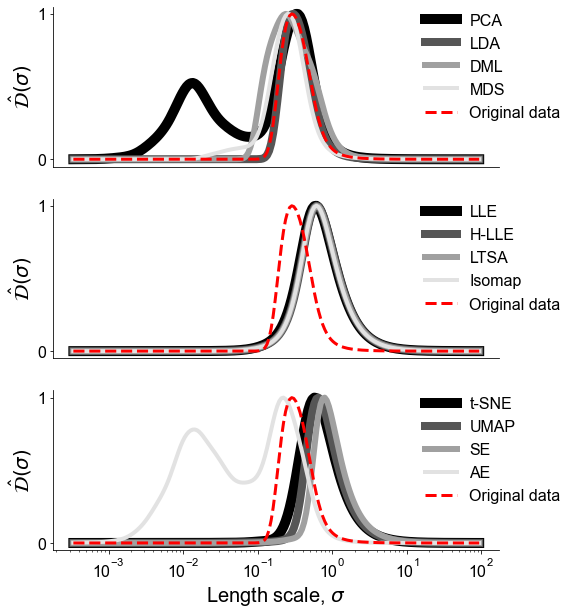

In [57]:
fig = plt.figure(figsize=(8, 10))
spec = fig.add_gridspec(ncols=4, nrows=2)
widths = [1]
heights = [1, 1, 1]
spec = fig.add_gridspec(ncols=1, nrows=3, width_ratios=widths, height_ratios=heights)

color_map_colors = cm.get_cmap('Greys')
colors = np.flipud(color_map_colors(np.linspace(0.2, 1, 4)))

ax = fig.add_subplot(spec[0,0])
ax.semilogx(sigma_PCA, derivative_PCA['var'], '-', color=colors[0], lw=10, label='PCA', zorder=3)
ax.semilogx(sigma_LDA, derivative_LDA['var'], '-', color=colors[1], lw=8,  label='LDA', zorder=4)
ax.semilogx(sigma_DML, derivative_DML['var'], '-', color=colors[2], lw=6,  label='DML', zorder=5)
ax.semilogx(sigma_MDS, derivative_MDS['var'], '-', color=colors[3], lw=4,  label='MDS', zorder=6)
plt.semilogx(sigma, derivative['var'], 'r--', lw=3, label='Original data', zorder=100)
plt.ylabel('$\hat{\mathcal{D}}(\sigma)$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks([])
plt.yticks([0,1], fontsize=16)
plt.minorticks_off()
plt.legend(ncol=1, fontsize=16, frameon=False, bbox_to_anchor=(0.8,1.05))

ax = fig.add_subplot(spec[1,0])
ax.semilogx(sigma_LLE, derivative_LLE['var'], '-', color=colors[0], lw=10, label='LLE', zorder=3)
ax.semilogx(sigma_HLLE, derivative_HLLE['var'], '-', color=colors[1], lw=8, markevery=5, label='H-LLE', zorder=4)
ax.semilogx(sigma_LTSA, derivative_LTSA['var'], '-', color=colors[2], lw=6, markevery=11, label='LTSA', zorder=5)
ax.semilogx(sigma_IMAP, derivative_IMAP['var'], '-', color=colors[3], lw=4, label='Isomap', zorder=6)
plt.semilogx(sigma, derivative['var'], 'r--', lw=3, label='Original data', zorder=100)
plt.ylabel('$\hat{\mathcal{D}}(\sigma)$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks([])
plt.yticks([0,1], fontsize=16)
plt.minorticks_off()
plt.legend(ncol=1, fontsize=16, frameon=False, bbox_to_anchor=(0.8,1.05))

ax = fig.add_subplot(spec[2,0])
ax.semilogx(sigma_TSNE, derivative_TSNE['var'], '-', color=colors[0], lw=10, label='t-SNE', zorder=3)
ax.semilogx(sigma_UMAP, derivative_UMAP['var'], '-', color=colors[1], lw=8, label='UMAP', zorder=4)
ax.semilogx(sigma_SE, derivative_SE['var'], '-', color=colors[2], lw=6, label='SE', zorder=5)
ax.semilogx(sigma_AE, derivative_AE['var'], '-', color=colors[3], lw=4, label='AE', zorder=6)
plt.semilogx(sigma, derivative['var'], 'r--', lw=3, label='Original data', zorder=100)
plt.xlabel('Length scale, $\sigma$', fontsize=20)
plt.ylabel('$\hat{\mathcal{D}}(\sigma)$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks(fontsize=16)
plt.yticks([0,1], fontsize=16)
plt.legend(ncol=1, fontsize=16, frameon=False, bbox_to_anchor=(0.8,1.05))

if save_figures: plt.savefig('../figures/swiss-roll-D-hat.svg', dpi=300, bbox_inches='tight')

***